<a href="https://colab.research.google.com/github/bassmang/Travel-guide/blob/master/Copy_of_Submission_for_COMP0090_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [0]:
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

In [0]:
using Pkg

pkg"add FiniteDifferences; precompile;"
using FiniteDifferences

pkg"add NamedArrays; precompile;"
using NamedArrays

pkg"add NPZ; precompile;"
using NPZ

pkg"add Plots; precompile;"
using Plots

using LinearAlgebra
using Random

# Assignment 1: “Bag, not bag” #

In [0]:
# Download and extract the dataset.
run(`curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o /tmp/data.tar.gz`)
run(`tar -x -z -f /tmp/data.tar.gz`)
run(`rm -f /tmp/data.tar.gz`);

In [0]:
# Then load it into RAM.
trainxs = npzread("comp0090_assignment_1_data/fashion-train-imgs.npz")
trainys = npzread("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = npzread("comp0090_assignment_1_data/fashion-dev-imgs.npz")
devys   = npzread("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = npzread("comp0090_assignment_1_data/fashion-test-imgs.npz")
testys  = npzread("comp0090_assignment_1_data/fashion-test-labels.npz");

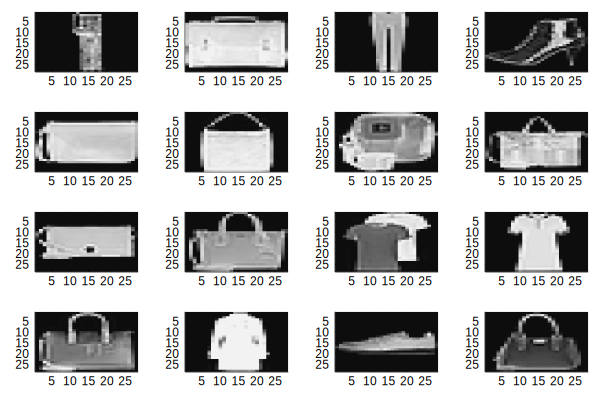

In [0]:
# Let us plot some random training samples.
plt = plot(layout=(4, 4))
for i in 1:4^2
    heatmap!(plt, trainxs[:, :, rand(1:size(trainxs, 3))]',
        subplot=i, yflip=true, color=:grays, colorbar = false)
end
plt

## Assignment 1.1: A memory-efficient voted perceptron ##



### 1. Derive a variant of the voted perceptron with memory complexity O(1)

**Result:** $\boldsymbol{\beta} = \sum_{i=1}^{k}c_i(\boldsymbol{w_i})$ \\
$\boldsymbol{w}: = 0^d$; \\
$\boldsymbol{c}: = 1$; \\
**while** *not converged* **do** \\
$~~~$ **for** $i:= 1,...,n$ **do** \\
$~~~~~~$ 
  $\hat{y} =
    \begin{cases}
      1 & \boldsymbol{w_k \cdot x_i} \geq 0\\
      0 & \text{else}
    \end{cases}$ \\
$~~~~~~$ **if** $\hat{y} = y$ **then** \\
$~~~~~~~~~ c:= c+1$; \\
$~~~~~~$ **else** \\
$~~~~~~~~~ \boldsymbol{\beta} := \boldsymbol{\beta} + c\boldsymbol{w}$; \\
$~~~~~~~~~ \boldsymbol{w} := 
\boldsymbol{w} + (y - \hat{y})\boldsymbol{x_i}$; \\
$~~~~~~~~~ c = 1$; \\
$~~~~~~$ **end** \\
$~~~$ **end** \\
**end** \\


### 2. Prove that your efficient variant is functionally equivalent to the voted perceptron.

The algorithm predicts based off $\sum_{i=1}^{k}c_i(\boldsymbol{w_i \cdot  x})$ and if we let $\boldsymbol{\beta} = \sum_{i=1}^{k}c_i(\boldsymbol{w_i})$ then we can predict using $\boldsymbol{\beta \cdot x}$ which is one d-dimensional vector, therefore the memory complexity is $O(1)$, rather than $O(k)$.


In the voted perceptron, k does not decrease, therefore we can iteratively add the $c_k \boldsymbol{w_k}$ terms to $\boldsymbol{\beta}$ without needing to store all of the terms.

### 3 & 4. Implement your efficient variant in your Colaboratory notebook and train your model to convergence on the training set.

In [0]:
acc(y, y_hat) = 1 - sum(broadcast(abs,(y-y_hat)))/length(y)

In [0]:
function y_pred(x, beta)   
  preds = []
  for i in 1:size(x)[2]
    if (beta'x[:,i])[1] >= 0
      push!(preds, 1)
    else
      push!(preds, 0)
    end
  end
  return preds
end

In [0]:
trainx = zeros((size(trainxs)[1]*size(trainxs)[2],size(trainxs)[3]))
devx = zeros((size(devxs)[1]*size(devxs)[2],size(devxs)[3]))
testx = zeros((size(testxs)[1]*size(testxs)[2],size(testxs)[3]))

for i in 1:size(trainxs)[3]
    trainx[:,i] = reshape(trainxs[:,:,i], size(trainxs)[1]*size(trainxs)[2], 1)
end
for i in 1:size(devxs)[3]
    devx[:,i] = reshape(devxs[:,:,i], size(devxs)[1]*size(devxs)[2], 1)
end
for i in 1:size(testxs)[3]
    testx[:,i] = reshape(testxs[:,:,i], size(testxs)[1]*size(testxs)[2], 1)
end

In [0]:
# Mutable structure for memory-efficient voted perceptron
mutable struct EfficientPerceptron
    beta ::Vector{Float64}
    w    ::Vector{Float64}
    c    ::Float64
end
# Initialising weights and bias
EfficientPerceptron(d) = EfficientPerceptron(
  zeros(d),
  zeros(d), 
  1.0)

In [0]:
train_accuracy = []
dev_accuracy = []
m = EfficientPerceptron(size(trainxs)[1]*size(trainxs)[2]) 
bestmodel = deepcopy(m)
bestacc = 0
#w = zeros(size(trainxs)[1]*size(trainxs)[2], 1);
# c =1;
# beta = zeros(size(trainxs)[1]*size(trainxs)[2], 1);
epochs = 5000
for iteration in 1:epochs  
  for i in 1:size(trainxs)[3]
    if (m.w'trainx[:,i])[1] >= 0
      y_hat = 1
    else
      y_hat = 0
    end
    if trainys[i] == y_hat
      m.c = m.c+1
    else
      m.beta = m.beta + m.c*m.w
      m.w = m.w + (trainys[i]-y_hat)*trainx[:,i]
      m.c = 1
    end
  end
  
  trainys_fitted = y_pred(trainx, m.beta)
  devys_fitted = y_pred(devx, m.beta)
  valid_acc = acc(devys, devys_fitted)
  push!(train_accuracy, acc(trainys, trainys_fitted))
  push!(dev_accuracy, valid_acc)

  # Break if accuracy is no longer increasing. This will signal convergence.
  if((iteration > 12) && (sum(broadcast(abs, train_accuracy[end - 10:end] - train_accuracy[end- 10-1:end-1])) == 0))
    println("Convergence after $iteration epochs")
    break
  end 

  #Update best parameters and best validation loss
  valid_acc > bestacc  || continue
  bestacc = valid_acc
  bestmodel = deepcopy(m)

   
end

Convergence after 247 epochs


### 5.Provide a plot of the accuracy on the training set for each epoch.

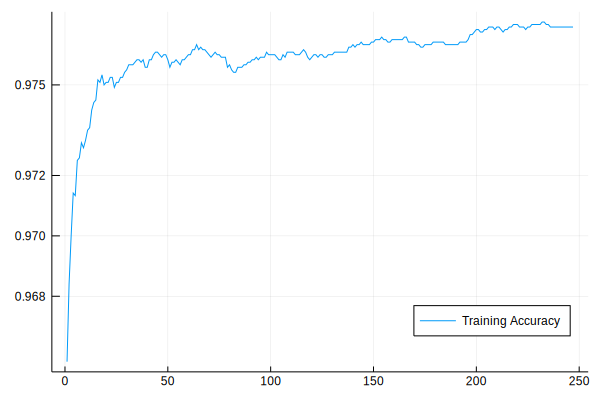

In [0]:
plot(1:length(train_accuracy), train_accuracy, label="Training Accuracy", legend = :bottomright)  

### 6.Provide the accuracy on the training and validation set, for the epoch on which you obtain your highest accuracy on the validation set.

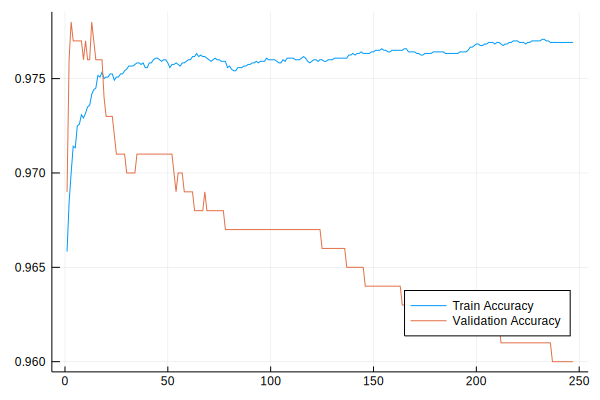

In [0]:
plot(1:length(train_accuracy), [train_accuracy, dev_accuracy], label=["Train Accuracy","Validation Accuracy"], legend = :bottomright) 

The accuracy is highest on the validation set for:

In [0]:
println("Epoch ", argmax(dev_accuracy))

Epoch 3


In [0]:
println("Training accuracy: ", acc(trainys, y_pred(trainx, bestmodel.beta))*100, "%")

Training accuracy: 97.0%


In [0]:
println("Validation accuracy: ", acc(devys, y_pred(devx, bestmodel.beta))*100, "%")

Validation accuracy: 97.8%


## Assignment 1.2: Mean squared-loss logistic regression ##


In [0]:
#Check size of data
size(trainxs), size(trainys), size(devxs), size(devys)

((28, 28, 12000), (12000,), (28, 28, 1000), (1000,))

The logistic function is defined as 
$$
  \sigma(x) = \frac{1}{1+e^{-x}} \qquad (1)
$$
We defined logistic regression as
$$
   f(\mathbf{x}) = \sigma(\mathbf{w}'\mathbf{x} + b) = \frac{1}{1+e^{-(\mathbf{w}'\mathbf{x} + b)}} \qquad (2)
$$
and so to get predicted labels 
$$
\hat{y}(\mathbf{x}) = 
\begin{cases} 
      1 & f(\mathbf{x}) \geq 0.5 \\ 
      0 & else        \\
   \end{cases}
   \qquad (3)
$$

In [0]:
### Using code from lectures

# (1) Logistic function
logistic(x) = (1 / (1 + exp(-x)))

# Mutable structure for Logistic Regression
mutable struct LogisticRegression
    w ::Vector{Float64}
    b ::Float64
end
# Initialising weights and bias
LogisticRegression(d)              = LogisticRegression(zeros(d), 0)

# (2) Logistic regression function
f(m::LogisticRegression, x)   = logistic(m.w'x + m.b)

# (3) Return predicted label
label(m::LogisticRegression, x)  = f(m, x) >= 0.5

label (generic function with 1 method)

In [0]:
# Reshape data - permute demensions
trainxs_rs = permutedims(trainxs, [3, 1, 2])
devxs_rs = permutedims(devxs, [3, 1, 2])
testxs_rs = permutedims(testxs, [3, 1, 2])

trainxs_rs = reshape(trainxs_rs, (size(trainxs_rs, 1), 28*28))
devxs_rs = reshape(devxs_rs, (size(devxs_rs, 1), 28*28))
testxs_rs = reshape(testxs_rs, (size(testxs_rs, 1), 28*28));

size(trainxs_rs), size(devxs_rs), size(testxs_rs)

((12000, 784), (1000, 784), (1000, 784))

In [0]:
#Initialising logistic regression for our features
model_m = LogisticRegression(size(trainxs_rs, 2));

Now we will compute accuracy and the loss function given in the question

In [0]:
function accuracy(y_true, m, X)
  """
  y_true: true labels
  m: fitted model parameters
  X: feature matrix

  returns accuracy
  """
  correct = 0
  for i in 1:size(X, 1)
    label(m, X[i, :]) == y_true[i] || continue
    correct += 1
  end
  correct / size(X, 1) * 100
end

function loss(y_true, m, X)
  """
  Mean-squared loss function
  y_true: true labels
  m: fitted model parameters
  X: feature matrix

  returns loss: value of loss function
  """
  loss = 0.0
  for i in 1:size(X, 1)
    loss += ( ( y_true[i] - f(m, X[i, :]) )^2 / 2 )
  end
  loss / size(X, 1)
end

loss (generic function with 1 method)

**Exercise 1 - Deriving gradients**

Now we derive the gradients by taking partial derivatives of the loss function w.r.t. both parameters (i.e. vector w and value b)

\begin{align*}
  \frac{\partial\mathcal{L}}{\partial\mathbf{w}} &= -\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)\hat{y_i} (1-\hat{y}_i)\mathbf{x}_i \\
  \frac{\partial\mathcal{L}}{\partial b} &= -\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)\hat{y_i} (1-\hat{y}_i)
\end{align*}

**Exercise 2 - Finite differences** 

To approximate the gradient of $f$, we will employ this secant approximation:

$$
  f'(x)\approx\frac{f(x+h) - f(x-h)}{2h}
$$

In [0]:
function finite_difference(X, m, h)
  """
  Computes derivative according to the formula above
  X: feature matrix
  m: fitted model parameters
  h: small value

  returns an array of gradients
  """
  #Initialise
  fdiff = deepcopy(m)
  fill!(fdiff.w, 0)
  fdiff.b = 0
  
  for i in 1:size(X, 1)   #each row of feature matrix
    for j in 1:size(X, 2) #each column
      w1          = deepcopy(m)
      w2          = deepcopy(m)
      w1.w[j]    += h
      w2.w[j]    -= h
      fdiff.w[j] += (f(w1, X[i, :]) - f(w2, X[i, :])) / (2*h)  #formula above
    end
    b1       = deepcopy(m)
    b2       = deepcopy(m)
    b1.b     += h
    b2.b     -= h
    fdiff.b  += (f(b1, X[i, :]) - f(b2, X[i, :])) / (2*h)
  end
 
  fdiff.w /= size(X, 1)
  fdiff.b /= size(X, 1)
  return fdiff
end

finite_difference (generic function with 1 method)

**Exercise 3 - implementing the algorithm**

Using Exercise 1,2 (commented as Ex(1), Ex(2))

In [0]:
#Fitting model for logistic regression

function fitLogisticReg(trainX, trainY, Xval, yval, learningrate, max_epochs)

  let m = LogisticRegression(size(trainX, 2));
    # Initialise
    bestValLoss = 1e8
    bestModel = deepcopy(m)
    valLosses = zeros(0)
    trainLosses = zeros(0)
    trainAcc = zeros(0)
    check = 0
    
    epoch = 1
    while check == 0 && epoch <= max_epochs
      gradient = deepcopy(m)
      fill!(gradient.w, 0) #fill w with 0s
      gradient.b = 0

      # Ex(1) Compute gradients as in the equations above
      for i in 1:size(trainX, 1)   #no. of rows of feature matrix
        x           = trainX[i, :] #x is one row of feature matrix
        y_hat       = f(m, x)      #logistic reg one observation
        gradient.w[:] .-= (trainY[i] - y_hat) * y_hat * (1 - y_hat) * x
        gradient.b     -= (trainY[i] - y_hat) * y_hat * (1 - y_hat) 
      end
      
      #Divide by number of observations n
      gradient.w ./= size(trainX, 1) 
      gradient.b  /= size(trainX, 1)

      # Ex(2) Verifying analytical gradients are correct, for first 3 runs
      if epoch < 4
        h = 1e-5
        fdiff = finite_difference(trainX, bestModel, h)
        wdiff = broadcast(abs, gradient.w - fdiff.w)
        bdiff = abs(gradient.b - fdiff.b)
        if (any(broadcast(abs, wdiff) .> 0.5)) || (bdiff > 0.5) 
          check += 1
        end
      end

      m.w .-= learningrate * gradient.w
      m.b  -= learningrate * gradient.b
      
      @show epoch currentTrainLoss = loss(trainY, m, trainX)
      currentValLoss = loss(yval, m, Xval)
      append!(trainLosses, currentTrainLoss)
      append!(trainAcc, accuracy(trainY, m, trainX))

      # When the algorithm converges
      if epoch > 80
        if (trainLosses[epoch-1] > trainLosses[epoch-80]) || (abs(trainLosses[epoch-1] - trainLosses[epoch-80]) <= 2e-4) 
          check += 1 
          println("Convergence after $epoch epochs")
        end
      end

      epoch +=1

      #Update best parameters and best validation loss
      currentValLoss < bestValLoss  || continue
      bestValLoss = currentValLoss
      bestModel = deepcopy(m)
    end

    # Return the resulting model parameters
    m.w[:] = bestModel.w[:]
    m.b    = bestModel.b;
    return m, trainLosses, trainAcc
  end
end

In [0]:
model_m, loss_train, acc_train = fitLogisticReg(trainxs_rs, trainys, devxs_rs, devys, 0.1, 5000)

**Exercise 5**

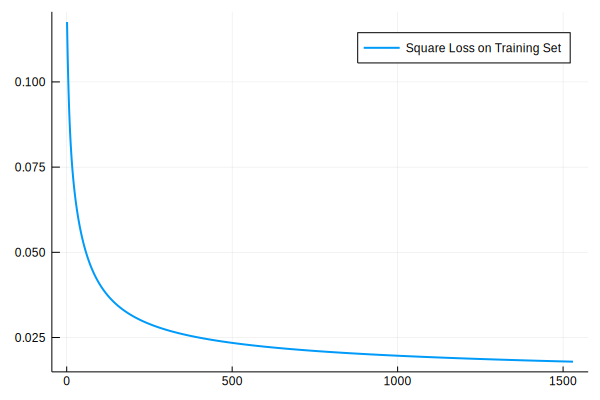

In [0]:
plt = plot(1:size(loss_train, 1), loss_train, label = "Square Loss on Training Set", lw = 2)

**Exercise 6**

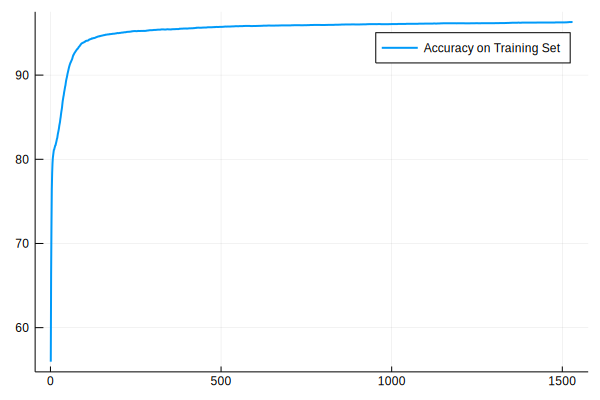

In [0]:
plt = plot(1:size(acc_train, 1), acc_train, label = "Accuracy on Training Set", lw = 2)

**Exercise 7**

In [0]:
#Final accuracy on training set
@show accuracy(trainys, model_m, trainxs_rs)
@show loss(trainys, model_m, trainxs_rs);

accuracy(trainys, model_m, trainxs_rs) = 96.30833333333332
loss(trainys, model_m, trainxs_rs) = 0.017911368154112373


In [0]:
#Final accuracy on validation set
@show accuracy(devys, model_m, devxs_rs)
@show loss(devys, model_m, devxs_rs);

accuracy(devys, model_m, devxs_rs) = 96.89999999999999
loss(devys, model_m, devxs_rs) = 0.01594248170671675


## Assignment 1.3: Three-Layer multi-layer perceptron ##

### 1. Assuming the log-likelihood loss, device the analytical gradients for the model parameters.

Given the following function definitions

\begin{align*}
  \sigma(x) = \frac{1}{1+e^{-x}}\\
  \sigma'(x) = \sigma(x)*(1 - \sigma(x))\\
  y' = \sigma(w_3\sigma(W_2\sigma(W_1x+b_1)+b_2)+b_3)
\end{align*}

And the activations:

\begin{align*}
  {h_1} =\sigma(W_1x+b_1) \\
  {h_2} =\sigma(W_2{h_1}+b_2)
\end{align*}

And the error values:

\begin{align*}
  {E_3} = y' - y \\
  {E_2} = (w_3E_3)*\sigma'(h2)\\
  {E_1} = (\sum_{rows}(W_2E_2)*(\sigma'(h_1))^T)^T
\end{align*}

The analytical gradient for each model parameter is as follows:

\begin{align*}
  \frac{\partial\mathcal{L}}{\partial\mathbf{b_3}} &= \frac{1}{n}\sum_{(x,y)}E_3\\
  \frac{\partial\mathcal{L}}{\partial\mathbf{w_3}} &= \frac{1}{n}\sum_{(x,y)}E_3*h_2\\
  \frac{\partial\mathcal{L}}{\partial\mathbf{b_2}} &= \frac{1}{n}\sum_{(x,y)}E_2\\
  \frac{\partial\mathcal{L}}{\partial\mathbf{W_2}} &= \frac{1}{n}\sum_{(x,y)}E_2*(h_1)^T\\
  \frac{\partial\mathcal{L}}{\partial\mathbf{b_1}} &= \frac{1}{n}\sum_{(x,y)}E_1\\
  \frac{\partial\mathcal{L}}{\partial\mathbf{W_1}} &= \frac{1}{n}\sum_{(x,y)}E_1*(x)^T
\end{align*}


### 2. Provide code verifying that your analytical gradients are correct using finite difference for two or more samples from the training data (you are free to use an external package that calculates the finite difference).

#####Reshape data so that each 28*28 image is a 748-length vector

In [0]:
trainx = zeros((size(trainxs)[1]*size(trainxs)[2],size(trainxs)[3]))
devx = zeros((size(devxs)[1]*size(devxs)[2],size(devxs)[3]))
testx = zeros((size(testxs)[1]*size(testxs)[2],size(testxs)[3]))

for i in 1:size(trainxs)[3]
    trainx[:,i] = reshape(trainxs[:,:,i], size(trainxs)[1]*size(trainxs)[2], 1)
end
for i in 1:size(devxs)[3]
    devx[:,i] = reshape(devxs[:,:,i], size(devxs)[1]*size(devxs)[2], 1)
end
for i in 1:size(testxs)[3]
    testx[:,i] = reshape(testxs[:,:,i], size(testxs)[1]*size(testxs)[2], 1)
end

#### Define the three layer perceptron

In [0]:
mutable struct ThreeLayerPerceptron
    W1 ::Matrix{Float64}
    b1 ::Vector{Float64}
    W2 ::Matrix{Float64}
    b2 ::Vector{Float64}
    w3 ::Vector{Float64}
    b3 ::Float64
end

ThreeLayerPerceptron(h1,h2) = ThreeLayerPerceptron(
    randn(h1, size(trainxs)[1]*size(trainxs)[2])./100,
    zeros(h1),
    randn(h2, h1)./100,
    zeros(h2),
    randn(h2)./100,
    0.0,
    );

#### Use code from lecture for finite difference

In [0]:
# Convenience function to zero out perceptron
import Base: zero
function zero(m::ThreeLayerPerceptron)
    gradm = deepcopy(m)
    fill!(gradm.W1, 0)
    fill!(gradm.b1, 0)
    fill!(gradm.W2, 0)
    fill!(gradm.b2, 0)
    fill!(gradm.w3, 0)
    gradm.b3 = 0
    gradm
end

# Create MLP
mlp = ThreeLayerPerceptron(4,4)

# Convenience function
function flatten(m::ThreeLayerPerceptron)
    toflatten = (m.W1, m.b1, m.W2, m.b2, m.w3, [m.b3])
    vec       = zeros(sum(length(x) for x in toflatten))
    offset    = 1
    for parameter in toflatten
        vec[offset:offset + length(parameter) - 1]  = parameter
        offset                                     += length(parameter)
    end
    vec
end

# Convenience function
function unflatten!(m::ThreeLayerPerceptron, vec)
    toflatten = (m.W1, m.b1, m.W2, m.b2, m.w3, [m.b3])
    offset    = 1
    for parameter in (m.W1, m.b1, m.W2, m.b2 ,m.w3)
        parameter[:]  = vec[offset:offset + length(parameter) - 1]
        offset       += length(parameter)
    end
    m.b3 = vec[end]
    m
end
@assert flatten(mlp) == flatten(unflatten!(zero(mlp), flatten(mlp)))

# Function to calculate finite difference
fdfprime(m, x, y) = fdfprime!(zero(m), m, x, y)
function fdfprime!(gradm, m, x, y)
    epsilon  = 0.000001
    vecm     = flatten(m)
    vecgradm = flatten(gradm)
    for i in eachindex(vecm)
        wi           = vecm[i]

        vecm[i]     += epsilon/2
        r            = loss(unflatten!(zero(m), vecm), x, y)
        vecm[i]      = wi
        vecm[i]     -= epsilon/2
        l            = loss(unflatten!(zero(m), vecm), x, y)
        vecgradm[i]  = (r - l)/epsilon

        vecm[i]      = wi
    end
    unflatten!(gradm, vecgradm)
end;

#### Define logistic and logisticprime operations

In [0]:
logistic(x)      = 1/(1 + exp(-x))
logisticprime(x) = logistic(x)*(1 - logistic(x));

#### Define the f and p functions

In [0]:
function f(m::ThreeLayerPerceptron, x)
  s1 = logistic.(m.W1*x + m.b1)
  s2 = logistic.(m.W2*s1 + m.b2)
  return logistic(dot(m.w3,s2) + m.b3)
end

p(m::ThreeLayerPerceptron, x) = f(m, x) >= .5;

#### Define the loss function

In [0]:
loss(m, x, y) = -log((1 - f(m, x))^(1 - y)) + -log(f(m, x)^y);

#### fprime! is a function used to update a gradient in motion, while fprime will apply an update to a zero-MLP

In [0]:
# Calculate gradients on zero perceptron
fprime(m, x, y) = fprime!(zero(m), m, x, y)

# Update gradients on gradm
function fprime!(gradm, m, x, y)
    # Forward pass
    h1     = logistic.(m.W1*x + m.b1)         # activations of first layer
    h2     = logistic.(m.W2*h1 + m.b2)        # activations of second layer
    h3     = dot(m.w3, h2) + m.b3             # activations of third layer
    yprime = logistic(h3)                     # output 

    # Backwards pass  
    error3        = yprime - y                 
    gradm.b3      += error3
    gradm.w3[:]   += error3*h2
    error2        = (m.w3*error3).*logisticprime.(h2)
    gradm.b2[:]   += error2
    gradm.W2[:,:] += error2*transpose(h1)
    error1        = transpose(sum((m.W2.*error2).*transpose(logisticprime.(h1)),dims=1))
    gradm.b1[:]   += error1
    gradm.W1[:,:] += error1*transpose(x)

    gradm
end;

#### Here I am providing the code to verify that my gradients are correct. I first select 2 random data points, both compute finite difference to gradient, then subtract the to see how much they differ. As you can see, the finite difference and gradients for my model are extremely similar, proving that the gradients are calculated correctly.

In [0]:
random_points = trunc.(Int,rand(2)*12000) # Two random points
i = 1 # Index variable
for r in random_points
    rand_x = trainx[:,r] # Random x
    rand_y = trainys[r] # Corresponding y
    finite_diffs = fdfprime(mlp,rand_x,rand_y) # Finite differences
    gradients = fprime(mlp,rand_x,rand_y) # Gradients
    println("Compare gradients to finite differences in point ",i,":")
    println("Difference in b3: ",gradients.b3 - finite_diffs.b3)
    println("Difference in w3: ",gradients.w3 .- finite_diffs.w3)
    println("Difference in b2: ",gradients.b2 .- finite_diffs.b2)
    println("Difference in W2: ",gradients.W2 .- finite_diffs.W2)
    println("Difference in b3: ",gradients.b1 .- finite_diffs.b1)
    println("Difference in W1: ",gradients.W1 .- finite_diffs.W1)
    i += 1 # Increment index
end;

Compare gradients to finite differences in point 1:
Difference in b3: 2.147125810481043e-10
Difference in w3: [-3.01081e-11, 5.28611e-11, 4.11008e-11, 4.8015e-11]
Difference in b2: [4.54339e-5, -1.83961e-5, -1.85056e-5, 0.000102313]
Difference in W2: [2.43431e-5 2.08991e-5 2.47486e-5 2.15827e-5; -9.85633e-6 -8.46214e-6 -1.00209e-5 -8.73876e-6; -9.91514e-6 -8.5126e-6 -1.00804e-5 -8.79085e-6; 5.48182e-5 4.70634e-5 5.57316e-5 4.86024e-5]
Difference in b3: [-2.31586e-8, -1.70577e-7, -1.88746e-7, 8.82602e-8]
Difference in W1: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.01311e-11 0.0 0.0 -1.84426e-9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.19213e-8 -1.37334e-8 -5.58862e-9 0.0 -4.15717e-11 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.43274e-10 0.0 -1.21247e-8 -3.47151e-9 0.0 -1.58598e-8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.01311e-11 0.0 -1


###3. Implement the algorithm in your Colaboratory notebook.



#### I have copied the main gradient function here as this is the crux of the MLP algorithm. Much of the code used for the algorithm is in the question above, as it was helpful for easily calculating gradients and comparing to the finite difference

In [0]:
# Calculate gradients on zero perceptron
fprime(m, x, y) = fprime!(zero(m), m, x, y)

# Update gradients on gradm
function fprime!(gradm, m, x, y)
    # Forward pass
    h1     = logistic.(m.W1*x + m.b1)         # activations of first layer
    h2     = logistic.(m.W2*h1 + m.b2)        # activations of second layer
    h3     = dot(m.w3, h2) + m.b3             # activations of third layer
    yprime = logistic(h3)                     # output 

    # Backwards pass  
    error3        = yprime - y                 
    gradm.b3      += error3
    gradm.w3[:]   += error3*h2
    error2        = (m.w3*error3).*logisticprime.(h2)
    gradm.b2[:]   += error2
    gradm.W2[:,:] += error2*transpose(h1)
    error1        = transpose(sum((m.W2.*error2).*transpose(logisticprime.(h1)),dims=1))
    gradm.b1[:]   += error1
    gradm.W1[:,:] += error1*transpose(x)

    gradm
end;

#### glorot initialisation function from lecture

In [0]:
fanin(W::Matrix)  = size(W)[2]
fanin(W::Vector)  = size(W)[1]
fanout(W::Matrix) = size(W)[1]
fanout(W::Vector) = 1

function glorot!(W; islogistic=true)
    x = sqrt(6/(fanin(W) + fanout(W)))*(islogistic ? 4 : 1)
    W[:] = -2x .* rand(size(W)...) .+ x
end;

#### Define accuracy of model


In [0]:
function accuracy(datax, datay, m)
    correct = 0
    for i in 1:length(datay)
        p(m, datax[:, i]) == datay[i] || continue
        correct += 1
    end
    correct/length(datay)*100
end;

###4. Train your model to convergence using full-batch gradient descent on the training set.

In [0]:
triple_m = ThreeLayerPerceptron(6,6) # Initialise new mlp to train
glorot!(triple_m.W1) # Intialize W1 using glorot
glorot!(triple_m.W2) # Intialize W2 using glorot
glorot!(triple_m.w3) # Intialize w3 using glorot
bestm   = deepcopy(triple_m) # This will store best-trained mlp for dev data
bestacc = 0.0 # This will store the best accuracy
max_epochs = 5000 # Set maximum number of epochs
losses = Float64[] # This will store the loss at each epoch
train_accuracies = Float64[] # This will store the train accuracy at each epoch
dev_accuracies = Float64[] # This will store the dev accuracy at each epoch

learningrate = .1

for iteration in 1:max_epochs
    # Initialise and zero gradient
    gradm = deepcopy(triple_m)
    gradm = zero(gradm)
    epoch_loss = 0

    # Apply gradient for each sample and add loss
    for i in 1:length(trainys)
        x  = trainx[:,i]
        y = trainys[i]
        fprime!(gradm, triple_m, x, y)
        epoch_loss += loss(triple_m, x, y)
    end

    # Calculate and append training loss
    epoch_loss /= length(trainys) # Normalize loss to size of dataset
    push!(losses,epoch_loss)

    # Scale gradient by size of training data
    gradm.W1 ./= length(trainys)
    gradm.b1 ./= length(trainys)
    gradm.W2 ./= length(trainys)
    gradm.b2 ./= length(trainys)
    gradm.w3 ./= length(trainys)
    gradm.b3  /= length(trainys)

    # Update weights and biases
    triple_m.W1  .-= learningrate*gradm.W1
    triple_m.b1  .-= learningrate*gradm.b1
    triple_m.W2  .-= learningrate*gradm.W2
    triple_m.b2  .-= learningrate*gradm.b2      
    triple_m.w3  .-= learningrate*gradm.w3
    triple_m.b3   -= learningrate*gradm.b3

    # Calculate and append training and dev accuracy
    train_acc = accuracy(trainx, trainys, triple_m)
    dev_acc = accuracy(devx, devys, triple_m)
    push!(train_accuracies,train_acc)
    push!(dev_accuracies,dev_acc)
    
    # Show iteration number and current training accuracy and loss
    @show iteration 
    @show dev_acc
    @show epoch_loss

    # Break if loss is no longer decreasing. This will signal convergence.
    if((iteration > 50) && ((epoch_loss - losses[iteration - 50]) > 0))
        break
    end   

    # Update best model and accuracy if necessary with best validation accuracy
    dev_acc > bestacc || continue
    bestm   = deepcopy(triple_m)
    bestacc = dev_acc

end

# Update perceptron values to best model
triple_m.W1[:,:] = bestm.W1[:,:]
triple_m.b1[:]   = bestm.b1[:]
triple_m.W2[:,:] = bestm.W2[:,:]
triple_m.b2[:]   = bestm.b2[:]
triple_m.w3[:]   = bestm.w3[:]
triple_m.b3      = bestm.b3;

###5. Provide a plot of the loss on the training set for each epoch.

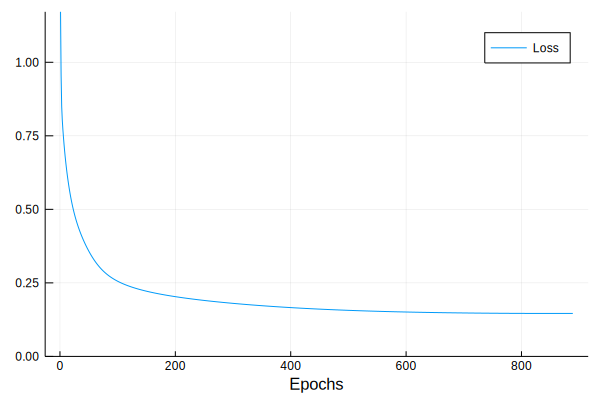

In [0]:
plot(1:length(losses),losses,ylims = (0,maximum(losses)),xlabel = "Epochs",label=["Loss"])

###6. Provide a plot of the accuracy on the training set for each epoch.

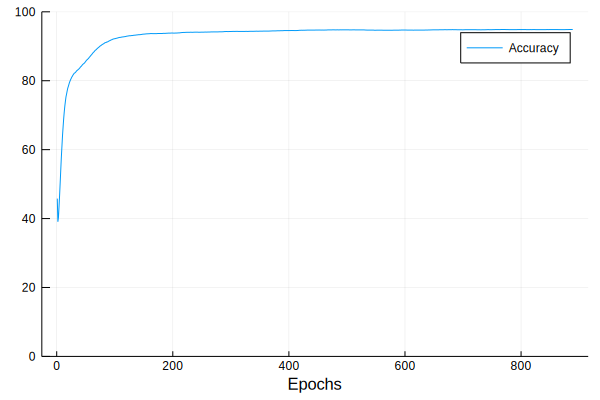

In [0]:
plot(1:length(train_accuracies),train_accuracies,ylims = (0,100),xlabel = "Epochs",label=["Accuracy"])

###7. Provide the accuracy on the training and validation set, for the epoch on which you obtain your highest accuracy on the validation set.

In [0]:
print("Train accuracy: ",accuracy(trainx, trainys, bestm),"%")

Train accuracy: 94.35833333333333%

In [0]:
print("Validation accuracy: ",accuracy(devx, devys, bestm),"%")

Validation accuracy: 95.7%

## Assignment 1.4: Hyperparameter tuning ##

Define sigmoid function and its derivative:

In [0]:
logistic(x)      = 1/(1 + exp(-x))
logisticprime(x) = logistic(x)*(1 - logistic(x))

Define the Two-Layer Perceptron as presented in the lecture:

In [0]:
mutable struct TwoLayerPerceptron
    W1 ::Matrix{Float64}
    b1 ::Vector{Float64}
    w2 ::Vector{Float64}
    b2 ::Float64
end
TwoLayerPerceptron(hids) = TwoLayerPerceptron(
        randn(hids, size(trainxs)[1]*size(trainxs)[2])./100,
        zeros(hids),
        randn(hids)./100,
        0.0,
    )
f(m::TwoLayerPerceptron, x) = logistic(dot(m.w2, logistic.(m.W1*x + m.b1)) + m.b2)  # predictive function
p(m::TwoLayerPerceptron, x) = f(m, x) >= 0.5                                        # boundary

mlp = TwoLayerPerceptron(3);


Define the loss function:

In [0]:
# loss function
loss(m, x, y) = -log((1 - f(m, x))^(1 - y)) + -log(f(m, x)^y)

Glorot initialisation as presented in the lecture:

In [0]:
# glorot initialisation
fanin(W::Matrix)  = size(W)[2]
fanin(W::Vector)  = size(W)[1]
fanout(W::Matrix) = size(W)[1]
fanout(W::Vector) = 1

function glorot!(W; islogistic=true)
    x = sqrt(6/(fanin(W) + fanout(W)))*(islogistic ? 4 : 1)
    W[:] = -2x .* rand(size(W)...) .+ x
end

Backpropagation algorithm as presented in the lecture:

In [0]:
# Convenience function
import Base: zero
function zero(m::TwoLayerPerceptron)
    gradm = deepcopy(m)
    glorot!(gradm.W1)
    fill!(gradm.b1, 0)
    glorot!(gradm.w2)
    gradm.b2 = 0
    gradm
end

# calculate gradients
fprime(m, x, y) = fprime!(zero(m), m, x, y)
function fprime!(gradm, m, x, y)
    # Forward pass
    h1     = logistic.(m.W1*x + m.b1)         # activations of first layer
    h2     = dot(m.w2, h1) + m.b2             # activations of second layer
    yprime = logistic(h2)                     # output 

    # Backwards pass  
    error2       = yprime - y                 # error
    gradm.b2    += error2                     # add error to bias
    gradm.w2[:] += error2*h1                  # backpropagation from last layer
    error1       = (m.w2*error2).*logisticprime.(h1)
    gradm.b1[:]   += error1
    gradm.W1[:,:] += error1*transpose(x)

    gradm
end;

Stack pixel matrices in vectors for input matrix:


In [0]:
trainx = zeros((size(trainxs)[1]*size(trainxs)[2],size(trainxs)[3]))
devx = zeros((size(devxs)[1]*size(devxs)[2],size(devxs)[3]))
testx = zeros((size(testxs)[1]*size(testxs)[2],size(testxs)[3]))

for i in 1:size(trainxs)[3]
    trainx[:,i] = reshape(trainxs[:,:,i], size(trainxs)[1]*size(trainxs)[2], 1)
end
for i in 1:size(devxs)[3]
    devx[:,i] = reshape(devxs[:,:,i], size(devxs)[1]*size(devxs)[2], 1)
end
for i in 1:size(testxs)[3]
    testx[:,i] = reshape(testxs[:,:,i], size(testxs)[1]*size(testxs)[2], 1)
end

Accuracy function:

In [0]:
function accuracy(datax, datay, m)
    correct = 0.0
    for i in 1:length(datay)
        p(m, datax[:, i]) == datay[i] || continue
        correct += 1
    end
    correct/length(datay)*100
end

Function to create batches as presented in the lecture:

In [0]:
batchify(x, n) = [x[i:min(i + n - 1, length(x))] for i in 1:n:length(x)]

**Exercise 1**

(a) (Full-)batch gradient descent without momentum:

In [0]:
mlp1 = TwoLayerPerceptron(3);

In [0]:
learningrate = 0.1

let m = mlp1
    bestm   = deepcopy(m)
    bestacc = 0.0

    epochs = 5000
    trainloss = zeros(epochs)

    convergence = 0
    convergence_epoch = 0

    for iteration in 1:epochs
        # shuffle at every epoch
        trainindx = shuffle(collect(1:1:length(trainys)))

        # initialise gradient
        gradm = deepcopy(m)
        gradm = zero(m)

        # Process
        for i in 1:length(trainys)
            x  = trainx[:,i]
            y = trainys[i]
            gradm = fprime!(gradm, m, x, y)
        end

        gradm.W1 ./= length(trainys)
        gradm.b1 ./= length(trainys)
        gradm.w2 ./= length(trainys)
        gradm.b2  /= length(trainys)

        # Update weights and biases
        m.W1  .-= learningrate*gradm.W1
        m.b1  .-= learningrate*gradm.b1
        m.w2  .-= learningrate*gradm.w2
        m.b2   -= learningrate*gradm.b2

        # store loss on training set
        for j in 1:length(trainys)
            trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
        end

        @show iteration currentvalacc = accuracy(devx, devys, m)
        if currentvalacc > bestacc 
            bestm   = deepcopy(m)
            bestacc = currentvalacc
        end

        # stop optimising if model has converged
        if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
            convergence = 1
            convergence_epoch = iteration
            break
        end

    end

    if convergence == 1 
        println("Convergence after $convergence_epoch epochs")
    else
        println("No convergence after $epochs epochs")
    end

    m.W1[:,:] = bestm.W1[:,:]
    m.b1[:]   = bestm.b1[:]
    m.w2[:]   = bestm.w2[:]
    m.b2      = bestm.b2;

end

@show accuracy(trainx, trainys, mlp1)
@show accuracy(devx, devys, mlp1)
@show accuracy(testx, testys, mlp1);

(b) Stochastic gradient descent without momentum:



In [0]:
mlp2 = TwoLayerPerceptron(3);

In [0]:
learningrate = 0.1

let m = mlp2
    bestm   = deepcopy(m)
    bestacc = 0.0

    epochs = 5000
    trainloss = zeros(epochs)

    convergence = 0
    convergence_epoch = 0

    for iteration in 1:epochs
        # shuffle at every epoch
        trainindx = shuffle(collect(1:1:length(trainys)))

        # Draw a random sample index
        indx = rand(trainindx)

        # Process and update 
        gradm = deepcopy(m)
        gradm = zero(m)

        # Process 
        x  = trainx[:,indx]
        y = trainys[indx]
        gradm = fprime!(gradm, m, x, y)

        # Update weights and biases
        m.W1  .-= learningrate*gradm.W1
        m.b1  .-= learningrate*gradm.b1
        m.w2  .-= learningrate*gradm.w2
        m.b2   -= learningrate*gradm.b2

        # store loss on training set
        for j in 1:length(trainys)
            trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
        end

        @show iteration currentvalacc = accuracy(devx, devys, m)
        if currentvalacc > bestacc 
            bestm   = deepcopy(m)
            bestacc = currentvalacc
        end

        # stop optimising if model has converged
        if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
            convergence = 1
            convergence_epoch = iteration
            break
        end

    end

    if convergence == 1 
        println("Convergence after $convergence_epoch epochs")
    else
        println("No convergence after $epochs epochs")
    end

    m.W1[:,:] = bestm.W1[:,:]
    m.b1[:]   = bestm.b1[:]
    m.w2[:]   = bestm.w2[:]
    m.b2      = bestm.b2;

end

@show accuracy(trainx, trainys, mlp2)
@show accuracy(devx, devys, mlp2)
@show accuracy(testx, testys, mlp2);

(c) Mini-batch gradient descent without momentum:

In [0]:
mlp3 = TwoLayerPerceptron(3);

In [0]:
learningrate = 0.01
batchsize    = 512

let m = mlp3
    bestm   = deepcopy(m)
    bestacc = 0.0

    epochs = 5000
    trainloss = zeros(epochs)

    convergence = 0
    convergence_epoch = 0

    for iteration in 1:epochs
        # shuffle at every epoch
        trainindx = shuffle(collect(1:1:length(trainys)))

        # Define mini-batches
        batches = batchify(trainindx, batchsize)

        # Process and update per Full-batch
        for batch in batches
            gradm = deepcopy(m)
            gradm = zero(m)

            # Process batch
            for i in batch
                x  = trainx[:,i]
                y = trainys[i]
                gradm = fprime!(gradm, m, x, y)
            end

            gradm.W1 ./= length(batch)
            gradm.b1 ./= length(batch)
            gradm.w2 ./= length(batch)
            gradm.b2  /= length(batch)

            # Update weights and biases
            m.W1  .-= learningrate*gradm.W1
            m.b1  .-= learningrate*gradm.b1
            m.w2  .-= learningrate*gradm.w2
            m.b2   -= learningrate*gradm.b2
        
        end

        # store loss on training set
        for j in 1:length(trainys)
            trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
        end

        @show iteration currentvalacc = accuracy(devx, devys, m)
        if currentvalacc > bestacc 
            bestm   = deepcopy(m)
            bestacc = currentvalacc
        end

        # stop optimising if model has converged
        if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
            convergence = 1
            convergence_epoch = iteration
            break
        end

    end

    if convergence == 1 
        println("Convergence after $convergence_epoch epochs")
    else
        println("No convergence after $epochs epochs")
    end

    m.W1[:,:] = bestm.W1[:,:]
    m.b1[:]   = bestm.b1[:]
    m.w2[:]   = bestm.w2[:]
    m.b2      = bestm.b2;

end

@show accuracy(trainx, trainys, mlp3)
@show accuracy(devx, devys, mlp3)
@show accuracy(testx, testys, mlp3);

(d) (Full-)batch gradient descent with momentum:

In [0]:
mlp4 = TwoLayerPerceptron(3);

In [0]:
learningrate = 0.1
momentum     = 0.95

let m = mlp4
    bestm   = deepcopy(m)
    bestacc = 0.0
    oldv    = deepcopy(m)
    fill!(oldv.W1, 0)
    fill!(oldv.b1, 0)
    fill!(oldv.w2, 0)
    oldv.b2 = 0

    epochs = 5000
    trainloss = zeros(epochs)

    convergence = 0
    convergence_epoch = 0

    for iteration in 1:epochs
        # shuffle at every epoch
        trainindx = shuffle(collect(1:1:length(trainys)))

        # initialise gradient an velocity
        gradm = deepcopy(m)
        oldm  = deepcopy(m)
        v = deepcopy(oldv)
        fill!(v.W1, 0)
        fill!(v.b1, 0)
        fill!(v.w2, 0)
        v.b2 = 0
        gradm = zero(m)

        # Process
        for i in 1:length(trainys)
            x  = trainx[:,i]
            y = trainys[i]
            gradm = fprime!(gradm, m, x, y)
        end

        gradm.W1 ./= length(trainys)
        gradm.b1 ./= length(trainys)
        gradm.w2 ./= length(trainys)
        gradm.b2  /= length(trainys)

        # update velocity and store it
        v.W1 = momentum.*oldv.W1-(1-momentum)*learningrate.*gradm.W1
        v.b1 = momentum.*oldv.b1-(1-momentum)*learningrate.*gradm.b1
        v.w2 = momentum.*oldv.w2-(1-momentum)*learningrate.*gradm.w2
        v.b2 = momentum*oldv.b2-(1-momentum)*learningrate*gradm.b2
        oldv = deepcopy(v)

        # Update weights and biases
        m.W1 = oldm.W1 + v.W1
        m.b1 = oldm.b1 + v.b1
        m.w2 = oldm.w2 + v.w2
        m.b2 = oldm.b2 + v.b2

        # store loss on training set
        for j in 1:length(trainys)
            trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
        end

        @show iteration currentvalacc = accuracy(devx, devys, m)
        if currentvalacc > bestacc 
            bestm   = deepcopy(m)
            bestacc = currentvalacc
        end

        # stop optimising if model has converged
        if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
            convergence = 1
            convergence_epoch = iteration
            break
        end

    end

    if convergence == 1 
        println("Convergence after $convergence_epoch epochs")
    else
        println("No convergence after $epochs epochs")
    end

    m.W1[:,:] = bestm.W1[:,:]
    m.b1[:]   = bestm.b1[:]
    m.w2[:]   = bestm.w2[:]
    m.b2      = bestm.b2;

end

@show accuracy(trainx, trainys, mlp4)
@show accuracy(devx, devys, mlp4)
@show accuracy(testx, testys, mlp4);

(e) Stochastic gradient descent with momentum:

In [0]:
mlp5 = TwoLayerPerceptron(3);

In [0]:
learningrate = 0.01
momentum     = 0.95

let m = mlp5
    bestm   = deepcopy(m)
    bestacc = 0.0
    oldv    = deepcopy(m)
    fill!(oldv.W1, 0)
    fill!(oldv.b1, 0)
    fill!(oldv.w2, 0)
    oldv.b2 = 0

    epochs = 5000
    trainloss = zeros(epochs)

    convergence = 0
    convergence_epoch = 0

    for iteration in 1:epochs
        # shuffle at every epoch
        trainindx = shuffle(collect(1:1:length(trainys)))

        # Draw a random sample index
        indx = rand(trainindx)

        # initialise gradient and velocity
        gradm = deepcopy(m)
        oldm = deepcopy(m)
        v = deepcopy(oldv)
        fill!(v.W1, 0)
        fill!(v.b1, 0)
        fill!(v.w2, 0)
        v.b2 = 0
        gradm = zero(m)

        # Process 
        x  = trainx[:,indx]
        y = trainys[indx]
        gradm = fprime!(gradm, m, x, y)

        # update velocity and store it
        v.W1 = momentum.*oldv.W1-(1-momentum)*learningrate.*gradm.W1
        v.b1 = momentum.*oldv.b1-(1-momentum)*learningrate.*gradm.b1
        v.w2 = momentum.*oldv.w2-(1-momentum)*learningrate.*gradm.w2
        v.b2 = momentum*oldv.b2-(1-momentum)*learningrate*gradm.b2
        oldv = deepcopy(v)

        # Update weights and biases
        m.W1 = oldm.W1 + v.W1
        m.b1 = oldm.b1 + v.b1
        m.w2 = oldm.w2 + v.w2
        m.b2 = oldm.b2 + v.b2

        # store loss on training set
        for j in 1:length(trainys)
            trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
        end

        @show iteration currentvalacc = accuracy(devx, devys, m)
        if currentvalacc > bestacc 
            bestm   = deepcopy(m)
            bestacc = currentvalacc
        end

        # stop optimising if model has converged
        if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
            convergence = 1
            convergence_epoch = iteration
            break
        end

    end

    if convergence == 1 
        println("Convergence after $convergence_epoch epochs")
    else
        println("No convergence after $epochs epochs")
    end

    m.W1[:,:] = bestm.W1[:,:]
    m.b1[:]   = bestm.b1[:]
    m.w2[:]   = bestm.w2[:]
    m.b2      = bestm.b2;

end

@show accuracy(trainx, trainys, mlp5)
@show accuracy(devx, devys, mlp5)
@show accuracy(testx, testys, mlp5);

(f) Mini-batch gradient descent with momentum:

In [0]:
mlp6 = TwoLayerPerceptron(3);

In [0]:
learningrate = 0.1
batchsize    = 256
momentum     = 0.95

let m = mlp6
    bestm   = deepcopy(m)
    bestacc = 0.0
    oldv    = deepcopy(m)
    fill!(oldv.W1, 0)
    fill!(oldv.b1, 0)
    fill!(oldv.w2, 0)
    oldv.b2 = 0

    epochs = 5000
    trainloss = zeros(epochs)

    convergence = 0
    convergence_epoch = 0

    for iteration in 1:epochs
        # shuffle at every epoch
        trainindx = shuffle(collect(1:1:length(trainys)))

        # Define mini-batches
        batches = batchify(trainindx, batchsize)

        # Process and update per Full-batch
        for batch in batches

            # initialise gradient and velocity
            gradm = deepcopy(m)
            oldm = deepcopy(m)
            v = deepcopy(oldv)
            fill!(v.W1, 0)
            fill!(v.b1, 0)
            fill!(v.w2, 0)
            v.b2 = 0
            gradm = zero(m)

            # Process batch
            for i in batch
                x  = trainx[:,i]
                y = trainys[i]
                gradm = fprime!(gradm, m, x, y)
            end

            gradm.W1 ./= length(batch)
            gradm.b1 ./= length(batch)
            gradm.w2 ./= length(batch)
            gradm.b2  /= length(batch)

            # update velocity and store it
            v.W1 = momentum.*oldv.W1-(1-momentum)*learningrate.*gradm.W1
            v.b1 = momentum.*oldv.b1-(1-momentum)*learningrate.*gradm.b1
            v.w2 = momentum.*oldv.w2-(1-momentum)*learningrate.*gradm.w2
            v.b2 = momentum*oldv.b2-(1-momentum)*learningrate*gradm.b2
            oldv = deepcopy(v)

            # Update weights and biases
            m.W1 = oldm.W1 + v.W1
            m.b1 = oldm.b1 + v.b1
            m.w2 = oldm.w2 + v.w2
            m.b2 = oldm.b2 + v.b2
        
        end

        # store loss on training set
        for j in 1:length(trainys)
            trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
        end

        @show iteration currentvalacc = accuracy(devx, devys, m)
        if currentvalacc > bestacc 
            bestm   = deepcopy(m)
            bestacc = currentvalacc
        end

        # stop optimising if model has converged
        if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
            convergence = 1
            convergence_epoch = iteration
            break
        end

    end

    if convergence == 1 
        println("Convergence after $convergence_epoch epochs")
    else
        println("No convergence after $epochs epochs")
    end

    m.W1[:,:] = bestm.W1[:,:]
    m.b1[:]   = bestm.b1[:]
    m.w2[:]   = bestm.w2[:]
    m.b2      = bestm.b2;

end

@show accuracy(trainx, trainys, mlp6)
@show accuracy(devx, devys, mlp6)
@show accuracy(testx, testys, mlp6);

**Exercise 2**

Grid search to find "good" hyperparameters:

In [0]:
learningrates = [0.04, 0.05, 0.06]
batchsizes    = [1024]
momentums     = [0.9]

hyperparamacc = zeros((length(learningrates),length(batchsizes), length(momentums)))

for (l, learningrate) in enumerate(learningrates)
    for (b, batchsize) in enumerate(batchsizes)
        for (n, momentum) in enumerate(momentums)

            mlp = TwoLayerPerceptron(3)

            let m = mlp
                bestm   = deepcopy(m)
                bestacc = 0.0
                bestlearn = 0.0
                bestbatch = 0
                bestmomentum = 0.0
                oldv    = deepcopy(m)
                fill!(oldv.W1, 0)
                fill!(oldv.b1, 0)
                fill!(oldv.w2, 0)
                oldv.b2 = 0
                    
                epochs = 1500
                trainloss = zeros(epochs)

                convergence = 0
                convergence_epoch = 0

                for iteration in 1:epochs
                    # shuffle at every epoch
                    trainindx = shuffle(collect(1:1:length(trainys)))

                    # Define mini-batches
                    batches = batchify(trainindx, batchsize)

                    # Process and update per mini-batch
                    for batch in batches

                        # initialise gradient and velocity
                        gradm = deepcopy(m)
                        oldm = deepcopy(m)
                        v = deepcopy(oldv)
                        fill!(v.W1, 0)
                        fill!(v.b1, 0)
                        fill!(v.w2, 0)
                        v.b2 = 0
                        gradm = zero(m)

                        # Process batch
                        for i in batch
                            x  = trainx[:,i]
                            y = trainys[i]
                            gradm = fprime!(gradm, m, x, y)
                        end

                        gradm.W1 ./= length(batch)
                        gradm.b1 ./= length(batch)
                        gradm.w2 ./= length(batch)
                        gradm.b2  /= length(batch)

                        # update velocity and store it
                        v.W1 = momentum.*oldv.W1-(1-momentum)*learningrate.*gradm.W1
                        v.b1 = momentum.*oldv.b1-(1-momentum)*learningrate.*gradm.b1
                        v.w2 = momentum.*oldv.w2-(1-momentum)*learningrate.*gradm.w2
                        v.b2 = momentum*oldv.b2-(1-momentum)*learningrate*gradm.b2
                        oldv = deepcopy(v)

                        # Update weights and biases
                        m.W1 = oldm.W1 + v.W1
                        m.b1 = oldm.b1 + v.b1
                        m.w2 = oldm.w2 + v.w2
                        m.b2 = oldm.b2 + v.b2
        
                    end

                    # store loss on training set
                    for j in 1:length(trainys)
                        trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
                    end

                    currentvalacc = accuracy(devx, devys, m)
                    if currentvalacc > bestacc 
                        bestm   = deepcopy(m)
                        bestacc = currentvalacc
                    end
                    hyperparamacc[l, b, n] = bestacc

                    # stop optimising if model has converged
                    if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
                        convergence = 1
                        convergence_epoch = iteration
                        break
                    end

                end

                @show l b n hyperparamacc[l, b, n]
                if convergence == 1 
                    println("Convergence after $convergence_epoch epochs")
                else
                    println("No convergence after $epochs epochs")
                end 

                m.W1[:,:] = bestm.W1[:,:]
                m.b1[:]   = bestm.b1[:]
                m.w2[:]   = bestm.w2[:]
                m.b2      = bestm.b2;

            end

        end
    end
end

@show hyperparamacc;

l = 1
b = 1
n = 1
hyperparamacc[l, b, n] = 94.3
No convergence after 1500 epochs
l = 2
b = 1
n = 1
hyperparamacc[l, b, n] = 94.39999999999999
Convergence after 265 epochs
l = 3
b = 1
n = 1
hyperparamacc[l, b, n] = 94.6
Convergence after 1281 epochs
hyperparamacc = [94.3; 94.4; 94.6]


**Exercise 3**

List of evaluated hyperparameters and description of strategy & results:

The general strategy was to start with a wide grid covering the smaller learning rates, the upper range of batch sizes (to provide smooth gradients) as well as the common range of momentum parameters and gradually refine the grid until no higher accuracy can be expected in the direct nieghbourhood.

Round one revealed that combinations spanning the smaller learning rates, smaller batch sizes and moderately large momentum parameters perform very well. Therefore, the second, third and fourth grid covered and refined these regions for varying learning rates. In round five and six, the larger learning rates were examined further, as they also performed reasonably well in round one.

The following table shows which parameters have been evaluated in which round:

|hyperparameter | 1 | 2 | 3 | 4 | 5 | 6 |
|----| | | | | | |
| learning rate | 0.001, 0.005, 0.01, 0.05 | 0.004, 0.005, 0.006 | 0.0001, 0.001, 0.002 | 0.0015, 0.002, 0.0025| 0.03, 0.05, 0.07 |0.04, 0.05, 0.06 |
| batch size | length(data), 2048, 1024 | 2048, 1024, 512 | 2048, 1024, 512 | 1024 | 2048, 1024, 512 |1024 |
| momentum | 0.99, 0.97, 0.95, 0.92 0.9 | 0.96, 0.95, 0.94 | 0.98, 0.97, 0.96 | 0.97 | 0.89, 0.9, 0.91 |0.9 |

The final hyperparameters $learning \, rate=0.0025$ ,  $batch \, size=1024$  and  $momentum=0.97$  achieved an accuracy of  $96.5%$  on the validation set.


**Exercise 4**

Plot of the loss on training and validation set for each epoch for the "good" parameters:

In [0]:
mlp = TwoLayerPerceptron(3);

In [0]:
# train the mlp with the "good" parameters
learningrate = 0.0025
batchsize    = 1024
momentum     = 0.97

epochs = 5000

trainloss = zeros(epochs)
valiloss  = zeros(epochs)
trainacc  = zeros(epochs)
valiacc   = zeros(epochs)

convergence = 0
convergence_epoch = 0

let m = mlp
    bestm   = deepcopy(m)
    bestacc = 0.0
    oldv    = deepcopy(m)
    fill!(oldv.W1, 0)
    fill!(oldv.b1, 0)
    fill!(oldv.w2, 0)
    oldv.b2 = 0

    for iteration in 1:epochs
        # Shuffle at every epoch
        trainindx = shuffle(collect(1:1:length(trainys)))

        # Define mini-batches
        batches = batchify(trainindx, batchsize)

        # Process and update per mini-batch
        for batch in batches

            # initialise gradient and velocity
            gradm = deepcopy(m)
            oldm = deepcopy(m)
            v = deepcopy(oldv)
            fill!(v.W1, 0)
            fill!(v.b1, 0)
            fill!(v.w2, 0)
            v.b2 = 0
            gradm = fprime(gradm, trainx[:,1], trainys[1])

            # Process batch
            for i in 1:length(trainys)
                x  = trainx[:,i]
                y = trainys[i]
                gradm = fprime!(gradm, m, x, y)
            end

            gradm.W1 ./= length(batch)
            gradm.b1 ./= length(batch)
            gradm.w2 ./= length(batch)
            gradm.b2  /= length(batch)

            # update velocity and store it
            v.W1 = momentum.*oldv.W1-(1-momentum)*learningrate.*gradm.W1
            v.b1 = momentum.*oldv.b1-(1-momentum)*learningrate.*gradm.b1
            v.w2 = momentum.*oldv.w2-(1-momentum)*learningrate.*gradm.w2
            v.b2 = momentum*oldv.b2-(1-momentum)*learningrate*gradm.b2
            oldv = deepcopy(v)

            # Update weights and biases
            m.W1 = oldm.W1 + v.W1
            m.b1 = oldm.b1 + v.b1
            m.w2 = oldm.w2 + v.w2
            m.b2 = oldm.b2 + v.b2
        
        end

        # store losses on training and validation set
        for j in 1:length(trainys)
            trainloss[iteration] += loss(m, trainx[:,j], trainys[j])/length(trainys)
        end 
        for j in 1:length(devys)
            valiloss[iteration] += loss(m, devx[:,j], devys[j])/length(devys)
        end

        # store accuracies on training and validation set
        trainacc[iteration] = accuracy(trainx, trainys, m)
        valiacc[iteration]  = accuracy(devx, devys, m)

        @show iteration currentvalacc = valiacc[iteration]
        if currentvalacc > bestacc 
            bestm   = deepcopy(m)
            bestacc = currentvalacc
        end

        # stop optimising if model has converged
        if iteration > 80 && abs(trainloss[iteration] - trainloss[iteration-80]) < 0.0001
            convergence = 1
            convergence_epoch = iteration
            break
        end

    end

    if convergence == 1 
        println("Convergence after $convergence_epoch epochs")
    else
        println("No convergence after $epochs epochs")
    end

    m.W1[:,:] = bestm.W1[:,:]
    m.b1[:]   = bestm.b1[:]
    m.w2[:]   = bestm.w2[:]
    m.b2      = bestm.b2;

end

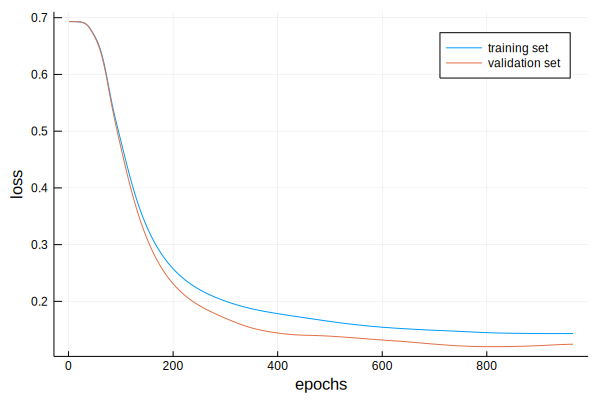

In [0]:
# plot the loss for training and validation set
let
    x = 1:convergence_epoch
    y = hcat(trainloss[1:convergence_epoch], valiloss[1:convergence_epoch])
    plot(x, y, label = ["training set","validation set"], xlabel = "epochs", ylabel = "loss")
end

**Exercise 5**

Plot of the accuracy on training and validation set for each epoch for the "good" parameters:

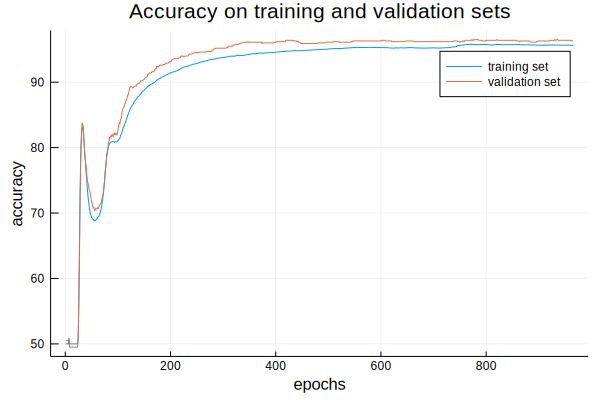

In [0]:
# plot accuracy on training and validation set
let
    x = 1:convergence_epoch
    y = hcat(trainacc[1:convergence_epoch], valiacc[1:convergence_epoch])
    plot(x, y, label = ["training set","validation set"])
    xlabel!("epochs")
    ylabel!("accuracy")
    title!("Accuracy on training and validation sets")
end

**Exercise 6**

Final accuracy on training and validation set for "good" hyperparameters:

In [0]:
println("Accuracy on training set:")
@show accuracy(trainx, trainys, mlp)
println("Accuracy on validation set:")
@show  accuracy(devx, devys, mlp);

Accuracy on training set:
accuracy(trainx, trainys, mlp) = 95.775
Accuracy on validation set:
accuracy(devx, devys, mlp) = 96.5


## Assignment 1.5: Model shootout ##


###1 & 2. Implement a “vanilla” perceptron model in your Colaboratory notebook, we will refer to this as our baseline model. Train your baseline model on the training set and use the validation set to determine when to stop training.

In [0]:
# Initialise "vanilla" perceptron parameters

w = zeros(size(trainx)[1])
b = 0.0
w_best = copy(w)
b_best = copy(b)
best_accuracy = 0.0

isbag(w,b,x) = dot(w, x) + b > 0

Accuracy for the vanilla perceptron:

In [0]:
function vanilla_accuracy(datax, datay, w, b)
    correct = 0
    for i in 1:length(datay)
        isbag(w, b, datax[:, i]) == datay[i] || continue
        correct += 1
    end
    correct/length(datay)*100
end

Training of the "vanilla" perceptron:

In [0]:
epochs = 5000
valid_accuracy = []

for iteration in 1:epochs
    for i in 1:length(trainys)
        x  = trainx[:,i]
        y = trainys[i]
        isbag(w, b, x) != y || continue
        if y == 1
            w .+= x
            b += 1
        else
            w .-=x
            b -= 1
        end
    end
    push!(valid_accuracy, vanilla_accuracy(devx, devys, w, b))

    #Saving the parameters for the best iteration in terms of validation accuracy
    if (valid_accuracy[iteration] > best_accuracy)
        w_best = copy(w)
        b_best = copy(b)
        best_accuracy = copy(valid_accuracy[iteration])
    end

    # Break if validation accuracy is no longer increasing. 
    if((iteration > 80) && (valid_accuracy[end] - valid_accuracy[end-80] < 0))
      println("Convergence after $iteration epochs")
      break 
    end
end

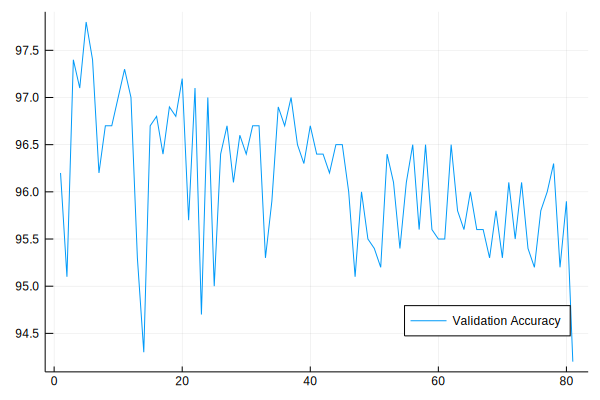

In [0]:
plot(1:length(valid_accuracy), valid_accuracy, label="Validation Accuracy", legend = :bottomright)  

The accuracy is highest on the validation set for:

In [0]:
println("Epoch ", argmax(valid_accuracy))

Epoch 5


In [0]:
println("Validation accuracy: ", vanilla_accuracy(devx, devys, w_best, b_best), "%")

Validation accuracy: 97.8%


In [0]:
println("Training accuracy: ", vanilla_accuracy(trainx, trainys, w_best, b_best), "%")

Training accuracy: 97.43333333333334%


### 3. Consider the models we have covered so far and attempt to significantly outperform the baseline model on the validation set.

Implementing a Three-Layer-Perceptron with hidden layers of 256 and 128 nodes respectively:

In [0]:
# Define logistic and logisticprime operations

logistic(x)      = 1/(1 + exp(-x))
logisticprime(x) = logistic(x)*(1 - logistic(x))

In [0]:
# Reshape data so that each 28*28 image is a 748-length vector

trainx = zeros((size(trainxs)[1]*size(trainxs)[2],size(trainxs)[3]))
devx = zeros((size(devxs)[1]*size(devxs)[2],size(devxs)[3]))
testx = zeros((size(testxs)[1]*size(testxs)[2],size(testxs)[3]))

for i in 1:size(trainxs)[3]
    trainx[:,i] = reshape(trainxs[:,:,i], size(trainxs)[1]*size(trainxs)[2], 1)
end
for i in 1:size(devxs)[3]
    devx[:,i] = reshape(devxs[:,:,i], size(devxs)[1]*size(devxs)[2], 1)
end
for i in 1:size(testxs)[3]
    testx[:,i] = reshape(testxs[:,:,i], size(testxs)[1]*size(testxs)[2], 1)
end

In [0]:
# glorot initialisation
fanin(W::Matrix)  = size(W)[2]
fanin(W::Vector)  = size(W)[1]
fanout(W::Matrix) = size(W)[1]
fanout(W::Vector) = 1

function glorot!(W; islogistic=true)
    x = sqrt(6/(fanin(W) + fanout(W)))*(islogistic ? 4 : 1)
    W[:] = -2x .* rand(size(W)...) .+ x
end

In [0]:
# Define the three layer perceptron

mutable struct ThreeLayerPerceptron
    W1 ::Matrix{Float64}
    b1 ::Vector{Float64}
    W2 ::Matrix{Float64}
    b2 ::Vector{Float64}
    w3 ::Vector{Float64}
    b3 ::Float64
end

ThreeLayerPerceptron(h1,h2) = ThreeLayerPerceptron(
    randn(h1, size(trainxs)[1]*size(trainxs)[2])./100,
    zeros(h1),
    randn(h2, h1)./100,
    zeros(h2),
    randn(h2)./100,
    0.0,
    )


In [0]:
# Define the f and p functions

function f(m::ThreeLayerPerceptron, x)
  s1 = logistic.(m.W1*x + m.b1)
  s2 = logistic.(m.W2*s1 + m.b2)
  return logistic(dot(m.w3,s2) + m.b3)
end

p(m::ThreeLayerPerceptron, x) = f(m, x) >= .5

In [0]:
# Define the loss function
loss(m, x, y) = -log((1 - f(m, x))^(1 - y)) + -log(f(m, x)^y)

In [0]:
# Convenience function to zero out perceptron
import Base: zero
function zero(m::ThreeLayerPerceptron)
    gradm = deepcopy(m)
    fill!(gradm.W1, 0)
    fill!(gradm.b1, 0)
    fill!(gradm.W2, 0)
    fill!(gradm.b2, 0)
    fill!(gradm.w3, 0)
    gradm.b3 = 0
    gradm
end

In [0]:
# Calculate gradients on zero perceptron
fprime(m, x, y) = fprime!(zero(m), m, x, y)

# Update gradients on gradm
function fprime!(gradm, m, x, y)
    # Forward pass
    h1     = logistic.(m.W1*x + m.b1)         # activations of first layer
    h2     = logistic.(m.W2*h1 + m.b2)        # activations of second layer
    h3     = dot(m.w3, h2) + m.b3            # activations of third layer
    yprime = logistic(h3)                     # output 

    # Backwards pass  
    error3        = yprime - y                 
    gradm.b3      += error3
    gradm.w3[:]   += error3*h2
    error2        = (m.w3*error3).*logisticprime.(h2)
    gradm.b2[:]   += error2
    gradm.W2[:,:] += error2*transpose(h1)
    error1        = transpose(sum((m.W2.*error2).*transpose(logisticprime.(h1)),dims=1))
    gradm.b1[:]   += error1
    gradm.W1[:,:] += error1*transpose(x)

    gradm
end

In [0]:
# Define accuracy of model

function accuracy(datax, datay, m)
    correct = 0
    for i in 1:length(datay)
        p(m, datax[:, i]) == datay[i] || continue
        correct += 1
    end
    correct/length(datay)*100
end

In [0]:
batchify(x, n) = [x[i:min(i + n - 1, length(x))] for i in 1:n:length(x)]

In [0]:
mlp_3layer = ThreeLayerPerceptron(256, 128) # Initialise new mlp
m = mlp_3layer 
bestm   = deepcopy(m)
bestacc = 0.0
oldv    = deepcopy(m)
fill!(oldv.W1, 0)
fill!(oldv.b1, 0)
fill!(oldv.W2, 0)
fill!(oldv.b2, 0)
fill!(oldv.w3, 0)
oldv.b3 = 0

glorot!(m.W1) # Intialize W1 using glorot
glorot!(m.W2) # Intialize W2 using glorot
glorot!(m.w3) # Intialize w3 using glorot
bestm   = deepcopy(m) # This will store best-trained mlp
bestacc = 0.0 # This will store the best accuracy
epochs = 50 # Set number of epochs

# This will store the losses for each epoch
train_losses = zeros(epochs)  
valid_losses = zeros(epochs)
test_losses = zeros(epochs)

# This will store the accuracies for each epoch
train_accuracies = zeros(epochs) 
valid_accuracies = zeros(epochs)
test_accuracies = zeros(epochs)

# Define convergence features
convergence = 0
convergence_epoch = 0

learningrate = .05
batchsize    = 32
momentum     = 0.95

for iteration in 1:epochs
    train_loss = 0

    #Learning rate is lowered for more precise updates later on in the process
    if iteration > 25
      learningrate = .01
    end
    trainindx = shuffle(collect(1:1:length(trainys)))

    # Define mini-batches
    batches = batchify(trainindx, batchsize)

    # Process and update per Full-batch
    for batch in batches
      # initialise gradient and velocity
      gradm = deepcopy(m)
      oldm = deepcopy(m)
      v = deepcopy(oldv)
      fill!(v.W1, 0)
      fill!(v.b1, 0)
      fill!(v.W2, 0)
      fill!(v.b2, 0)
      fill!(v.w3, 0)
      v.b3 = 0

      gradm = fprime(gradm, trainx[:,1], trainys[1])

      # Process batch
      for i in batch
        x  = trainx[:,i]
        y = trainys[i]
        gradm = fprime!(gradm, m, x, y)
        train_loss  += loss(m, x, y)
      end

      # Scale gradient by size of training data
      gradm.W1 ./= length(batch)
      gradm.b1 ./= length(batch)
      gradm.W2 ./= length(batch)
      gradm.b2  /= length(batch)
      gradm.w3 ./= length(batch)
      gradm.b3  /= length(batch)

      # update velocity and store it
      v.W1 = momentum.*oldv.W1-(1-momentum)*learningrate.*gradm.W1
      v.b1 = momentum.*oldv.b1-(1-momentum)*learningrate.*gradm.b1
      v.W2 = momentum.*oldv.W2-(1-momentum)*learningrate.*gradm.W2
      v.b2 = momentum.*oldv.b2-(1-momentum)*learningrate*gradm.b2
      v.w3 = momentum.*oldv.w3-(1-momentum)*learningrate.*gradm.w3
      v.b3 = momentum*oldv.b3-(1-momentum)*learningrate*gradm.b3
      oldv = deepcopy(v)

      # Update weights and biases
      m.W1 = oldm.W1 + v.W1
      m.b1 = oldm.b1 + v.b1
      m.W2 = oldm.W2 + v.W2
      m.b2 = oldm.b2 + v.b2
      m.w3 = oldm.w3 + v.w3
      m.b3 = oldm.b3 + v.b3
        
    end
    
    #Calculating and storing the losses for the training, validation and test sets

    train_loss /= length(trainys) 
    train_losses[iteration] = train_loss
 
    for i in 1:size(devys)[1]
      x  = devx[:,i]
      y = devys[i]
      valid_losses[iteration] += loss(m, x, y)/size(devys)[1]
    end

    for i in 1:size(testys)[1]
      x  = testx[:,i]
      y = testys[i]
      test_losses[iteration] += loss(m, x, y)/size(testys)[1]
    end

    #Calculating and storing the accuracies for the training, validation and test sets

    train_accuracies[iteration] = accuracy(trainx, trainys, m)
    valid_accuracies[iteration] = accuracy(devx, devys, m)
    test_accuracies[iteration] = accuracy(testx, testys, m)
    

    # Show iteration number and current validation accuracy
    @show iteration 
    @show valid_accuracies[iteration]
    @show train_losses[iteration]


    # Update best model and accuracy if necessary
    valid_accuracies[iteration] > bestacc || continue
    bestm   = deepcopy(m)
    bestacc = valid_accuracies[iteration]

    if iteration > 10 && abs(train_losses[iteration] - train_losses[iteration-10]) < 1.0e-7
      convergence = 1
      convergence_epoch = iteration
      break
    end
    
end

if convergence == 1 
  println("Convergence after $convergence_epoch epochs")
else
  println("No convergence after $epochs epochs")
end

# Update perceptron values to best model
m.W1[:,:] = bestm.W1[:,:]
m.b1[:]   = bestm.b1[:]
m.W2[:,:] = bestm.W2[:,:]
m.b2[:]   = bestm.b2[:]
m.w3[:]   = bestm.w3[:]
m.b3      = bestm.b3;

### 4. Briefly describe in one or three paragraphs how you approached the task and what your final best model is, also listing its hyperparameters.

The "vanilla" perceptron performs well on the data despite just being a linear classifier. Therefore we decided that we should not need to increase the number of hidden layers further (from the three-layer MLP in Question 3) and fit excessively complex functions. 

In Question 3 we trained a 3-layer MLP with 6 & 6 nodes in the hidden layers. This is essentially dimensionality reduction and may have been detrimentally reducing the information in the data during the transition from the input vector to the first hidden layer. Therefore we increased the number of nodes in the hidden layers to 256 & 128 in order utilise the 784-dimensional input vectors more effectively.

This larger model naturally trains slower so we have attempted to choose hyperparameters in order to speed up the process whilst not damaging performance. For fast training we ran mini-batch gradient descent with momentum using a relatively high learning rate of 0.05 (which falls to 0.01 by epoch 25), a low batch-size of 32 and a momentum constant of 0.95. Note that the model trains for just 50 epochs and does not completely converge due to time-constraints.

### 5. Provide a plot of the loss on the training, validation, and test set for each epoch for your best model.

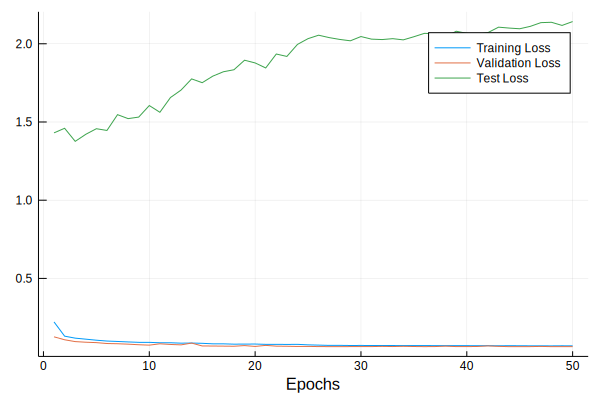

In [0]:
plot(1:length(train_losses), [train_losses, valid_losses, test_losses], xlabel = "Epochs",label=["Training Loss", "Validation Loss", "Test Loss"])

####6. Provide a plot of the accuracy on the training, validation, and test set for each epoch for your best model.

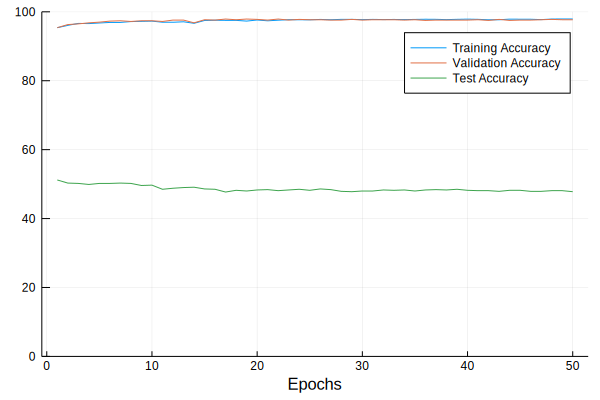

In [0]:
plot(1:length(train_accuracies), [train_accuracies, valid_accuracies, test_accuracies], ylims = (0,100),xlabel = "Epochs",label=["Training Accuracy", "Validation Accuracy", "Test Accuracy"])

####Provide the accuracy on the training, validation, and test set for your best model, for the epoch on which you obtain your highest accuracy on the validation set.

In [0]:
print("Train accuracy: ",accuracy(trainx, trainys, bestm),"%")

Train accuracy: 97.52499999999999%

In [0]:
print("Validation accuracy: ",accuracy(devx, devys, bestm),"%")

Validation accuracy: 97.89999999999999%

In [0]:
print("Test accuracy: ",accuracy(testx, testys, bestm),"%")

Test accuracy: 47.699999999999996%